In [27]:
from reverb.training.utils import DEFAULT_TRAINING_KWARGS, DEFAULT_MODEL_KWARGS, DEFAULT_DATA_KWARGS
import segmentation_models_pytorch as smp

experiments = {
    "supervised/baseline": {
        "run_name": "ablations/supervised/baseline",
        "training_kwargs": {
            "max_epochs": 20,
        },
        "model_kwargs": DEFAULT_MODEL_KWARGS,
        "data_kwargs": DEFAULT_DATA_KWARGS,
    },
    "semisupervised/alpha_0.98": {
        "run_name": "ablations/semisupervised/alpha_0.98",
        "training_kwargs": {
            "max_epochs": 50,
            "alpha": 0.98,
        },
        "model_kwargs": DEFAULT_MODEL_KWARGS,
        "data_kwargs": DEFAULT_DATA_KWARGS,
    },
    "synthetic/baseline_fine": {
        "run_name": "ablations/synthetic/baseline_fine",
        "training_kwargs": {
            "max_epochs": 50,
        },
        "finetuning_kwargs": {
            "max_epochs": 12,   
            "lr": 1e-5,
            # "weight_decay": 0.0,
        },
        "model_kwargs": DEFAULT_MODEL_KWARGS,
        "data_kwargs": DEFAULT_DATA_KWARGS,
    }
}

In [28]:
from reverb.training.utils import train, get_eval_dataloaders, compute_results_over_eval_sets, save_evaluation_results
eval_dataloaders = get_eval_dataloaders()


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [34]:
import os
import json
import pandas as pd
experiment_names = experiments.keys()

# Root directory containing experiment folders like 'baseline_model_0/', 'baseline_model_1/', etc.
experiments_root = './checkpoints/ablations'
import os
import json

flattened_data = []

for exp_name in experiment_names:
    exp_dir = os.path.join(experiments_root, os.path.dirname(exp_name))
    exp_base = os.path.basename(exp_name)

    # Find folders that start with the experiment name and end with a number
    matching_folders = [
        os.path.join(os.path.dirname(exp_name), d)
        for d in os.listdir(exp_dir)
        if os.path.isdir(os.path.join(exp_dir, d)) and d.startswith(exp_base + '_')
    ]

    for folder in matching_folders:
        results_path = os.path.join(experiments_root, folder, 'eval_results.json')
        if os.path.isfile(results_path):
            with open(results_path, 'r') as f:
                datasets = json.load(f)
            for dataset, metrics in datasets.items():
                for metric, value in metrics.items():
                    if metric in ['miou', 'precision', 'recall']:
                        flattened_data.append({
                            'Experiment': exp_name,     # Original exp_name without repeat suffix
                            'Repeat': folder,           # Full nested folder name
                            'Dataset': dataset,
                            'Metric': metric,
                            'Value': value
                        })
# Convert to DataFrame
df = pd.DataFrame(flattened_data)

# Compute mean and SEM over repeats for each experiment
mean_df = (
    df.groupby(['Experiment', 'Dataset', 'Metric'])['Value']
    .mean()
    .reset_index()
    .rename(columns={'Value': 'Mean'})
)

sem_df = (
    df.groupby(['Experiment', 'Dataset', 'Metric'])['Value']
    .sem()
    .reset_index()
    .rename(columns={'Value': 'Std_Error'})
)

# Merge summaries
summary_df = pd.merge(mean_df, sem_df, on=['Experiment', 'Dataset', 'Metric'])

# Save outputs
df.to_csv('individual_repeat_results.csv', index=False)
summary_df.to_csv('supervised_experiment_summary.csv', index=False)

print("Saved individual repeat results and summary statistics.")


Saved individual repeat results and summary statistics.


In [35]:
# Filter only for 'miou'
miou_df = summary_df[summary_df['Metric'] == 'miou']

# Print one table per dataset
for dataset in miou_df['Dataset'].unique():
    print(f"\n--- Dataset: {dataset} ---")
    display(miou_df[miou_df['Dataset'] == dataset].drop(columns=['Metric']))



--- Dataset: rr_eval ---


,Experiment,Dataset,Mean,Std_Error
0,semisupervised/alpha_0.98,rr_eval,0.500459,0.019855
9,supervised/baseline,rr_eval,0.515835,0.008360
18,synthetic/baseline_fine,rr_eval,0.494717,0.006108



--- Dataset: up34_eval ---


,Experiment,Dataset,Mean,Std_Error
3,semisupervised/alpha_0.98,up34_eval,0.472154,0.009551
12,supervised/baseline,up34_eval,0.493216,0.016052
21,synthetic/baseline_fine,up34_eval,0.532353,0.006543



--- Dataset: valid ---


,Experiment,Dataset,Mean,Std_Error
6,semisupervised/alpha_0.98,valid,0.431697,0.001525
15,supervised/baseline,valid,0.416180,0.002065
24,synthetic/baseline_fine,valid,0.441315,0.002045


In [39]:
df

,Experiment,Repeat,Dataset,Metric,Value
0,supervised/baseline,supervised/baseline_1,valid,precision,0.572370
1,supervised/baseline,supervised/baseline_1,valid,recall,0.595661
2,supervised/baseline,supervised/baseline_1,valid,miou,0.412213
3,supervised/baseline,supervised/baseline_1,rr_eval,precision,0.633235
4,supervised/baseline,supervised/baseline_1,rr_eval,recall,0.728615
...,...,...,...,...,...
76,synthetic/baseline_fine,synthetic/baseline_fine_1,rr_eval,recall,0.723259
77,synthetic/baseline_fine,synthetic/baseline_fine_1,rr_eval,miou,0.506709
78,synthetic/baseline_fine,synthetic/baseline_fine_1,up34_eval,precision,0.617277
79,synthetic/baseline_fine,synthetic/baseline_fine_1,up34_eval,recall,0.819328


In [40]:
from tabulate import tabulate
import pandas as pd

# Define your target datasets and metrics
datasets_order = ['valid', 'up34_eval', 'rr_eval']
dataset_labels = {
    'valid': 'UP05 Validation Set',
    'up34_eval': 'UPFLOW UP34',
    'rr_eval': 'RHUM-RUM RR40'
}
metrics_order = ['miou', 'precision', 'recall']

# Create a multi-level header: each dataset gets 3 metric sub-columns
headers = ['Model Type']
column_tuples = []

for dataset in datasets_order:
    for metric in metrics_order:
        column_tuples.append((dataset, metric))

# Build rows
rows = []
model_types = sorted(summary_df['Experiment'].unique())

for experiment in model_types:
    row = [experiment]
    for dataset in datasets_order:
        for metric in metrics_order:
            subset = summary_df[
                (summary_df['Experiment'] == experiment) &
                (summary_df['Dataset'] == dataset) &
                (summary_df['Metric'] == metric)
            ]
            if not subset.empty:
                mean = subset['Mean'].values[0]
                sem = subset['Std_Error'].values[0]
                formatted = f"\\SI[mode=text]{{{mean:.2f} \\pm {sem:.2f}}}{{}}"
            else:
                formatted = '--'
            row.append(formatted)
    rows.append(row)

# Create final column headers for LaTeX
header_lines = [
    ['Dataset'] + [dataset_labels[d] for d in datasets_order for _ in metrics_order],
    ['Metric'] + metrics_order * len(datasets_order),
]

# Convert to LaTeX manually with proper formatting
def latex_table_manual(headers, rows):
    top_line = "\\begin{table*}\n\\centering\n\\small\n\\setlength{\\tabcolsep}{4pt}\n"
    top_line += "\\caption{Metrics for each of the training techniques, evaluated on each of the evaluation datasets.\n"
    top_line += "The mean performance and standard error over three independent training runs are reported for each metric.}\n"
    top_line += "\\label{tab:results}\n\\begin{tabular}{l" + "ccc|" * (len(datasets_order) - 1) + "ccc}\n\\toprule\n"

    # Write multi-level header
    h1 = headers[0]
    h2 = headers[1]

    line1 = f"{h1[0]} & " + ' & '.join([f"\\multicolumn{{3}}{{c|}}{{{h}}}" if i < len(h1) - 1 else f"\\multicolumn{{3}}{{c}}{{{h}}}" for i, h in enumerate(h1[1:])]) + " \\\\\n"
    line2 = f"{h2[0]} & " + ' & '.join(h2[1:]) + " \\\\\n\\midrule\n"

    # Write data rows
    body = ""
    for row in rows:
        body += row[0] + " & " + ' & '.join(row[1:]) + " \\\\\n"

    bottom = "\\bottomrule\n\\end{tabular}\n\\end{table*}"

    return top_line + line1 + line2 + body + bottom

latex_output = latex_table_manual(header_lines, rows)
print(latex_output)


\begin{table*}
\centering
\small
\setlength{\tabcolsep}{4pt}
\caption{Metrics for each of the training techniques, evaluated on each of the evaluation datasets.
The mean performance and standard error over three independent training runs are reported for each metric.}
\label{tab:results}
\begin{tabular}{lccc|ccc|ccc}
\toprule
Dataset & \multicolumn{3}{c|}{UP05 Validation Set} & \multicolumn{3}{c|}{UP05 Validation Set} & \multicolumn{3}{c|}{UP05 Validation Set} & \multicolumn{3}{c|}{UPFLOW UP34} & \multicolumn{3}{c|}{UPFLOW UP34} & \multicolumn{3}{c|}{UPFLOW UP34} & \multicolumn{3}{c|}{RHUM-RUM RR40} & \multicolumn{3}{c|}{RHUM-RUM RR40} & \multicolumn{3}{c|}{RHUM-RUM RR40} \\
Metric & miou & precision & recall & miou & precision & recall & miou & precision & recall \\
\midrule
semisupervised/alpha_0.98 & \SI[mode=text]{0.43 \pm 0.00}{} & \SI[mode=text]{0.62 \pm 0.01}{} & \SI[mode=text]{0.59 \pm 0.01}{} & \SI[mode=text]{0.47 \pm 0.01}{} & \SI[mode=text]{0.52 \pm 0.01}{} & \SI[mode=text]{

In [8]:
from reverb.training.utils import load_best_model_from_run
models = {}
for exp_name, exp_config in experiments.items():
    model = load_best_model_from_run(
        run_name=exp_config['run_name'] + '_2',  # Assuming we want the first repeat
        model_kwargs=exp_config['model_kwargs'],
        training_kwargs=exp_config['training_kwargs'],
    )
    models[exp_name] = model


{'model_type': <class 'segmentation_models_pytorch.decoders.unet.model.Unet'>, 'encoder_name': 'resnet18', 'encoder_weights': 'imagenet', 'in_channels': 1, 'classes': 2}
{'model_type': <class 'segmentation_models_pytorch.decoders.unet.model.Unet'>, 'encoder_name': 'resnet18', 'encoder_weights': 'imagenet', 'in_channels': 1, 'classes': 2}
{'model_type': <class 'segmentation_models_pytorch.decoders.unet.model.Unet'>, 'encoder_name': 'resnet18', 'encoder_weights': 'imagenet', 'in_channels': 1, 'classes': 2}


In [10]:
import torch
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
valid_dataloader = eval_dataloaders['valid']
valid_dataset_batch = next(iter(valid_dataloader))
all_pred_masks = {} 

for name, model in models.items():
    model.to(device)
    model.eval()
    threshold = 0.5 if 'synthetic' in name else 0.5
    print(threshold)
    with torch.no_grad():
        eval_dataloader = valid_dataloader
        for batch in eval_dataloader:
            images, masks = batch
            images, masks = images.to(device), masks.to(device)
            y_pred = model(images)
            probs = F.softmax(y_pred, dim=1)  # shape: (B, 2, H, W)

            # Get class 1 probability and apply threshold
            class1_prob = probs[:, 1, :, :]  # shape: (B, H, W)
            masks_pred = (class1_prob > threshold).long().cpu().numpy()
    all_pred_masks[name] = masks_pred

0.5
0.5
0.5


In [12]:
# find indices where true masks sum to non-zero
non_zero_indices = valid_dataset_batch[1].sum(dim=(1, 2)) > 1000
# print the actual index values
print("Indices with non-zero true masks:", non_zero_indices.nonzero(as_tuple=True)[0].tolist())


Indices with non-zero true masks: [21, 26, 27, 32, 37, 38, 51, 57, 60, 63, 69, 70, 74, 78, 86, 87, 100, 104]


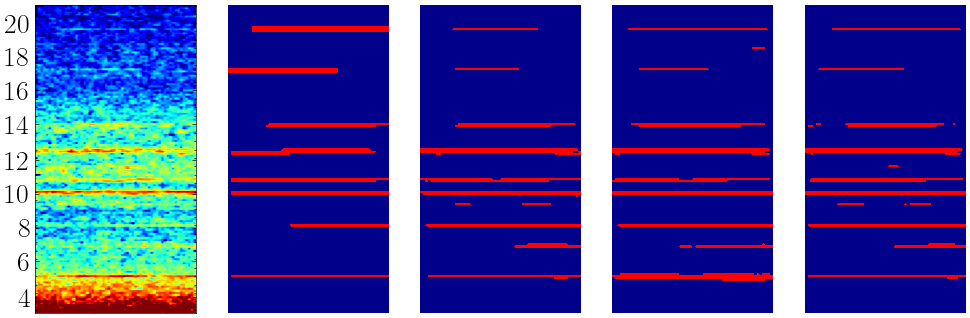

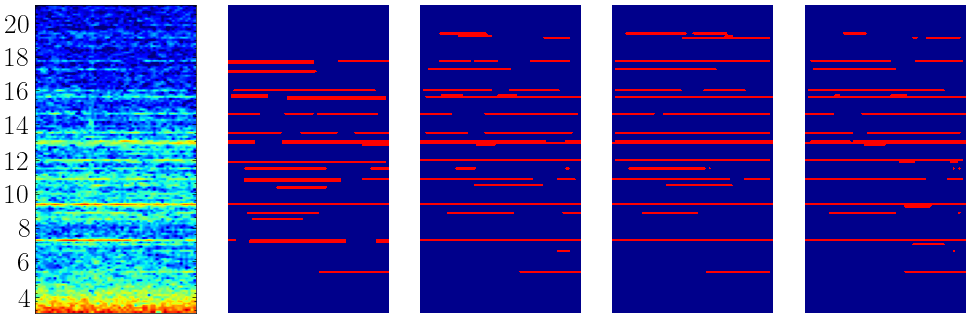

In [26]:
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

# set font size for all plots
plt.rcParams.update({'font.size': 20})

def apply_crop(input, indices):
    cropped_spectrogram = np.flipud(np.flipud(input)[indices, :])
    return cropped_spectrogram

colors = ['darkblue','red']
cmap_masks = plt.cm.colors.ListedColormap(colors)
exp_patterns = ['supervised', 'test_finetune']
def plot_valid_predictions(indices,                       # three sample indices
                           images,                        # shape (N, 1, H, W) or (N, H, W)
                           masks_true,                    # shape (N, H, W)
                           all_pred_masks,                # dict: name -> np.ndarray (N, H, W)
                           save_dir="results",
                           trim_rows=17,
                           vmin=0.25, vmax=0.75,
                           cmap_masks="tab20"):
    """
    Draws one row per index: raw image | GT mask | one column per model prediction.
    Saves each figure as results/whale_predictions_<idx>.png and shows it.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Ensure images are 3‑D (N, H, W) for imshow.
    if images.ndim == 4:          # (N, C, H, W)
        images = images.squeeze(1)  # assume single‑channel
    images = images[ :, :-trim_rows, :-4]
    masks_true = masks_true[:, :-trim_rows, :-4]
    model_names = list(all_pred_masks.keys())
    n_cols      = 2 + len(model_names)
    n_rows      = len(indices)
    spec_frequencies = np.linspace(1.01, 50.0, 399)
    freq_mask = (spec_frequencies >= 3) & (spec_frequencies <= 21)
    freq_indices = np.where(freq_mask)[0]
    cropped_frequencies = spec_frequencies[freq_indices][::-1]

    for idx in indices:
        fig, axs = plt.subplots(1, n_cols,
                                figsize=(2 * n_cols + 2, 4))

        # --- column 0: raw spectrogram ----------------------------------------------------------
        image = images[idx]
        image = apply_crop(image, freq_indices)

        axs[0].imshow(image, aspect="auto",
                      cmap="jet", vmin=vmin, vmax=vmax)

        # --- column 1: ground‑truth mask --------------------------------------------------------
        mask_true = apply_crop(masks_true[idx], freq_indices)
        axs[1].imshow(mask_true, aspect="auto",
                      cmap=cmap_masks)

        # --- remaining columns: one per model ---------------------------------------------------
        for j, name in enumerate(model_names, start=2):
            pred_mask = all_pred_masks[name][idx][:-trim_rows, :-4]
            pred_mask = apply_crop(pred_mask, freq_indices)
            axs[j].imshow(pred_mask,
                          aspect="auto", cmap=cmap_masks)

        # cosmetic: hide spines / ticks except first column’s y‑ticks
        for j, ax in enumerate(axs):
            if j != 0:  # hide everything for masks/preds
                ax.set_xticks([]); ax.set_xticklabels([])
                ax.set_yticks([]); ax.set_yticklabels([])
                ax.axis("off")
            else:       # first column keeps y‑ticks for context
                major_tick_positions = []
                major_tick_freqs = [4, 6, 8, 10, 12, 14, 16, 18, 20]
                for freq in major_tick_freqs:
                    # This finds the index in the array where the value is nearest to `freq`
                    closest_index = np.abs(cropped_frequencies - freq).argmin()
                    major_tick_positions.append(closest_index)

                # 3. Set the major ticks at the found positions with the desired labels
                ax.set_yticks(major_tick_positions)
                ax.set_yticklabels(major_tick_freqs)

                # 4. Turn on automatic minor ticks
                # Matplotlib will now add unlabeled ticks between your major ones.
                ax.minorticks_on()

                # You can keep your existing lines to hide the x-ticks
                ax.set_xticks([])
                ax.set_xticklabels([])

        # save & show ---------------------------------------------------------------------------
        out_path = os.path.join(save_dir, f"res/res_predictions_{idx}.png")
        plt.savefig(out_path, dpi=300, transparent=True)
        plt.show()
        plt.close(fig)

images_cpu = valid_dataset_batch[0].cpu().numpy()
masks_cpu  = valid_dataset_batch[1].cpu().numpy()
import scienceplots

with plt.style.context(['science']):
    plot_valid_predictions(indices=[100,105],
                        images=images_cpu,
                        masks_true=masks_cpu,
                        all_pred_masks=all_pred_masks,
                        cmap_masks=cmap_masks,)
